In [79]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import json

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns




# Target

In [80]:
def get_target(input_df, ticker):
    df = input_df.copy()
    df["Target"] = (df[f"Close_{ticker}"].shift(-1) > df[f"Close_{ticker}"]).astype(int)
    df.dropna(inplace=True)
    return df

# Target TBM ( Triple Barrier Method)

In [81]:
def get_tbm_target(df, ticker, horizon=5, pt_sl=[1.2,1]):
    df = df.copy()
    close = df[f'Close_{ticker}']
    
    log_ret = np.log(close / close.shift(1))
    volatility = log_ret.rolling(window=20).std()
    
    targets = pd.Series(index=df.index, dtype=float)
    
    for i in range(len(df) - horizon):
        price_start = close.iloc[i]
        current_vol = volatility.iloc[i] ### dynamic barrier for each day
        
        upper_barrier = price_start * (1 + current_vol * pt_sl[0])
        lower_barrier = price_start * (1 - current_vol * pt_sl[1])
        
        future_prices = close.iloc[i+1 : i+ 1 + horizon]
        
        targets.iloc[i] = 0
        
        for price_future in future_prices:
            if price_future >= upper_barrier:
                targets.iloc[i] = 1 # profit taking hit
                break
            elif price_future <= lower_barrier:
                targets.iloc[i] = -1 # stop loss hit
                break
    df['Target'] = targets
    return df.dropna(subset=['Target'])

# Model: Ensemble (Voting Soft)
### With optuna to optimized

In [82]:
def build_ensemble_model_vote(X_train, y_train):
    def objective(trial):
        # for Random Forest
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 200)
        rf_max_depth = trial.suggest_int("rf_max_depth", 3, 10)
        
        # for XGBoost
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.2, log=True)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 6)
        
        # for SVM
        svm_c = trial.suggest_float("svm_c", 0.1, 10.0, log=True)
        
        lr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial' ,random_state=42))
    ])
        rf_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators= rf_n_estimators,
            max_depth= rf_max_depth,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])  
        svm_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=svm_c,
            gamma="scale",
            class_weight='balanced',
            probability=True,
            random_state=42
        ))
    ])
        
        xgb_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            n_estimators=100,
            max_depth= xgb_max_depth,
            learning_rate= xgb_learning_rate,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss"
        ))
    ])
        
        ensemble = VotingClassifier(
            estimators= [('lr', lr_pipe),('rf', rf_pipe), ('svm', svm_pipe), ('xgb', xgb_pipe)],
            voting='soft'
        )
        
        tscv = TimeSeriesSplit(n_splits=3)
        score = cross_val_score(ensemble, X_train, y_train, cv=tscv, scoring='f1_weighted')
        
        return score.mean()
    
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)
        
    best = study.best_params    
    lr_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000,
                                  solver='lbfgs',
                                  multi_class='multinomial',
                                  random_state=42))
    ])

    rf_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators=best['rf_n_estimators'],
            max_depth=best['rf_max_depth'],
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])

    svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=best['svm_c'],
            gamma="scale",
            class_weight='balanced',
            probability=True,
            random_state=42
        ))
    ])

    xgb_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            n_estimators=100,
            max_depth=best['xgb_max_depth'],
            learning_rate=best['xgb_learning_rate'],
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss"
        ))
    ])

    model = VotingClassifier(
        estimators=[
            ("lr", lr_pipeline),
            ("rf", rf_pipeline),
            ("svm", svm_pipeline),
            ("xgb", xgb_pipeline),
        ],
        voting="soft"
    )
    return model

### Sample Weights

In [83]:
def get_sample_weights(df, horizon=5):
    # create a binary matrix indicating which days are covered by which barrier
    num_rows = len(df)
    concurrency = np.zeros(num_rows)

    for i in range(num_rows - horizon):
        concurrency[i  : i + horizon] += 1

    uniqueness = 1.0 / np.maximum(concurrency, 1)

    weights = pd.Series(index=df.index, dtype=float)
    for i in range(num_rows - horizon):
        weights.iloc[i] = uniqueness[i : i + horizon].mean()
        
    return weights.fillna(0)

# Walk Forward validation with purging and embargo in validation


In [84]:
def walk_forward_validation_with_purging(
    df,
    features,
    model_version,
    target_col="Target",
    date_col="DATE",
    start_year=2010,
    first_train_end_year=2015,
    last_test_year=2023,
    horizon = 5,
    embargo_pct = 0.01
):

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    all_y_true = []
    all_y_pred = []
    all_y_proba = []

    fold_rows = []

    sample_weights_all = get_sample_weights(df, horizon)
    
    for train_end_year in range(first_train_end_year, last_test_year):
        test_year = train_end_year + 1

        train_mask = (df[date_col].dt.year >= start_year) & (df[date_col].dt.year <= train_end_year)
        test_mask = (df[date_col].dt.year == test_year)

        train_df = df[train_mask]
        test_df = df[test_mask]

        # jeżeli jakiś rok nie ma danych to skip
        if len(train_df) < 200 or len(test_df) < 50:
            continue

        ## Purging
        train_df_purged = train_df.iloc[:-horizon]
        weights_train = sample_weights_all.loc[train_df_purged.index] 
        
        ## Embargo
        embargo_size = int(len(df) * embargo_pct)
        test_df_embargo = test_df.iloc[embargo_size:]
        
        if len(test_df_embargo) < 10: continue
        
        
        X_train = train_df_purged[features]
        y_train = train_df_purged[target_col]

        X_test = test_df_embargo[features]
        y_test = test_df_embargo[target_col]

        model = model_version(X_train,  y_train)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) 

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        auc = roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr')

        fold_rows.append({
            "train_end_year": train_end_year,
            "test_year": test_year,
            "n_train": len(train_df),
            "n_test": len(test_df),
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "roc_auc": auc
        })

        all_y_true.extend(y_test.tolist())
        all_y_pred.extend(y_pred.tolist())
        all_y_proba.extend(y_proba.tolist())

    folds_df = pd.DataFrame(fold_rows)

    return folds_df, np.array(all_y_true), np.array(all_y_pred), np.array(all_y_proba)




# Block bootstrap

In [85]:
def block_bootstrap_accuracy(y_true, y_pred, block_size=20, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)

    if n < block_size:
        raise ValueError("Za mało danych do bootstrapa w tej konfiguracji.")

    acc_samples = []

    for _ in range(n_bootstrap):
        sampled_idx = []

        while len(sampled_idx) < n:
            start = rng.integers(0, n - block_size + 1)
            block = list(range(start, start + block_size))
            sampled_idx.extend(block)

        sampled_idx = sampled_idx[:n]
        y_true_bs = y_true[sampled_idx]
        y_pred_bs = y_pred[sampled_idx]

        acc = accuracy_score(y_true_bs, y_pred_bs)
        acc_samples.append(acc)

    acc_samples = np.array(acc_samples)
    ci_low = np.percentile(acc_samples, 2.5)
    ci_high = np.percentile(acc_samples, 97.5)

    return acc_samples, ci_low, ci_high



# Walk_forward + Bootstrap

In [86]:


def run_stage4_for_ticker(df_raw, ticker, selected_features, model_version):
    df = get_tbm_target(df_raw, ticker)

    selected_features = [f for f in selected_features if f in df.columns]

    folds_df, y_true_all, y_pred_all, y_proba_all = walk_forward_validation_with_purging(
        df=df,
        features=selected_features,
        model_version=model_version,
        target_col="Target",
        date_col="DATE",
        start_year=2010,
        first_train_end_year=2015,
        last_test_year=2023 
    )

    print("=" * 60)
    print(f" WALK-FORWARD RESULTS for {ticker}")
    metrics = ["accuracy", "precision", "recall", "roc_auc"]
    summary_mean = folds_df[metrics].mean()

    print("\n--- Summary ---")
    print(summary_mean.to_frame(name="Mean").T)
     
    print("\n--- Detailed Classification Report (Whole Period) ---")    
    print(classification_report(y_true_all, y_pred_all, zero_division=0))
    
    # Block Bootstrap
    acc_samples, ci_low, ci_high = block_bootstrap_accuracy(
        y_true=y_true_all,
        y_pred=y_pred_all,
        block_size=20,
        n_bootstrap=1000
    )

    print("\n" + "=" * 60)
    print(f" BLOCK BOOTSTRAP for {ticker}")
    print(f"95% CI accuracy: [{ci_low:.4f}, {ci_high:.4f}]")
    print(f"Bootstrap mean accuracy: {acc_samples.mean():.4f}")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true_all, y_pred_all)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Loss (-1)', 'Neutral (0)', 'Profit (1)'],
                yticklabels=['Loss (-1)', 'Neutral (0)', 'Profit (1)'])
    plt.title(f'Confusion Matrix for {ticker}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return folds_df, acc_samples


# Example use

------AAPL-----
Selected features for AAPL:
Running for AAPL with selected features (15)
 WALK-FORWARD RESULTS for AAPL

--- Summary ---
      accuracy  precision    recall   roc_auc
Mean  0.443441   0.427974  0.443441  0.553564

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.42      0.48      0.45       592
         0.0       0.24      0.15      0.18       282
         1.0       0.51      0.52      0.52       738

    accuracy                           0.44      1612
   macro avg       0.39      0.39      0.38      1612
weighted avg       0.43      0.44      0.43      1612


 BLOCK BOOTSTRAP for AAPL
95% CI accuracy: [0.3995, 0.4851]
Bootstrap mean accuracy: 0.4423


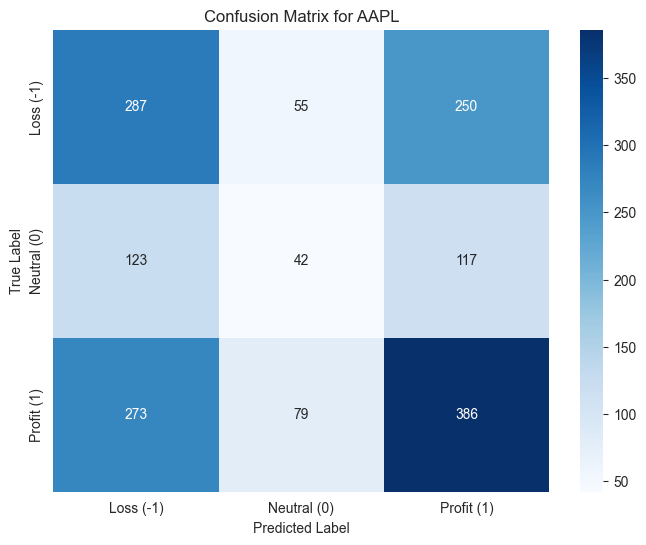

------GOOGL-----
Selected features for GOOGL:
Running for GOOGL with selected features (27)
 WALK-FORWARD RESULTS for GOOGL

--- Summary ---
      accuracy  precision    recall   roc_auc
Mean  0.372797   0.389151  0.372797  0.586201

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.37      0.47      0.41       608
         0.0       0.19      0.12      0.15       338
         1.0       0.44      0.41      0.42       666

    accuracy                           0.37      1612
   macro avg       0.33      0.33      0.33      1612
weighted avg       0.36      0.37      0.36      1612


 BLOCK BOOTSTRAP for GOOGL
95% CI accuracy: [0.3393, 0.4113]
Bootstrap mean accuracy: 0.3740


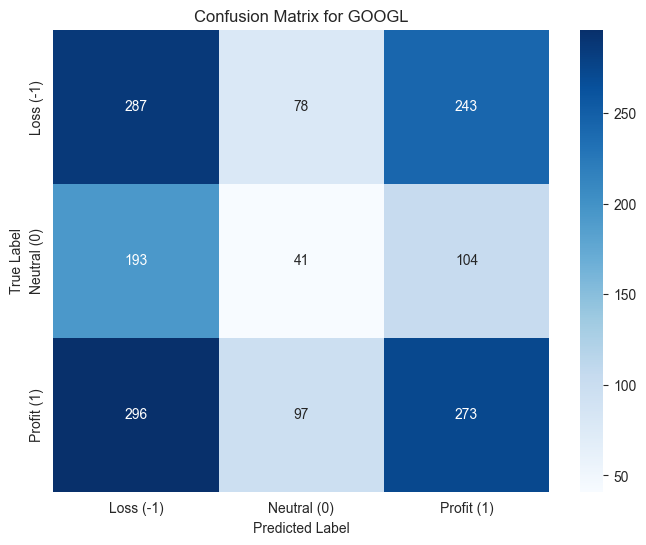

------MSFT-----
Selected features for MSFT:
Running for MSFT with selected features (15)
 WALK-FORWARD RESULTS for MSFT

--- Summary ---
      accuracy  precision    recall   roc_auc
Mean  0.386974   0.390376  0.386974  0.566786

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.30      0.32      0.31       576
         0.0       0.31      0.15      0.20       315
         1.0       0.47      0.54      0.50       721

    accuracy                           0.39      1612
   macro avg       0.36      0.34      0.34      1612
weighted avg       0.38      0.39      0.37      1612


 BLOCK BOOTSTRAP for MSFT
95% CI accuracy: [0.3517, 0.4256]
Bootstrap mean accuracy: 0.3877


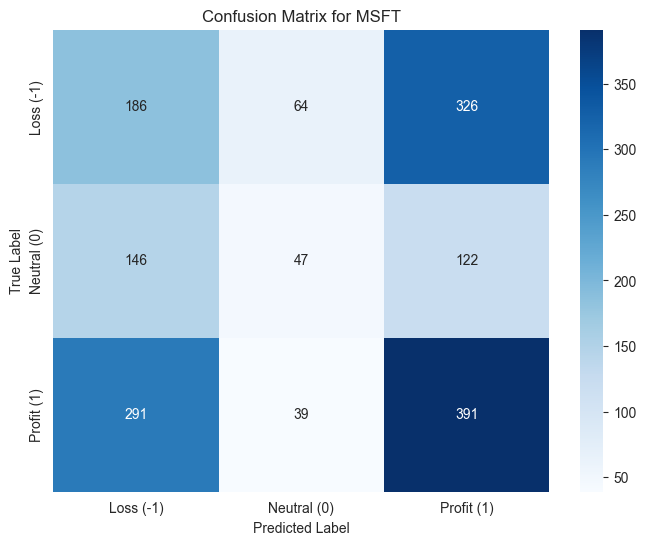

In [87]:

tickers = ["AAPL", "GOOGL", "MSFT"]

with open("../../selected_features/feature_dict.json", "r") as f:
    feature_dict = json.load(f)


def get_all_features(df):
    return [c for c in df.columns if c not in ["DATE", "index", "Target"]]

for share in tickers:
    data = pd.read_csv(f"../../data/all_data/all_{share}_data.csv")
    df_tmp = get_tbm_target(data, share)
    features_aapl = get_all_features(df_tmp)
    print(f"------{share}-----")
        
    selected_features = feature_dict[share]
    print(f"Selected features for {share}:")
    # print(f"Running for {share} with all features ({len(features_aapl)})")
    # run_stage4_for_ticker(data, share, features_aapl)
    print(f"Running for {share} with selected features ({len(selected_features)})")
    run_stage4_for_ticker(data, share, selected_features, model_version=build_ensemble_model_vote)